#  Linear Separability
This notebook performs the following tasks step by step:
1. **Examines Year 1** and removes overlapping points.
2. **Computes a linear decision boundary** to separate Green and Red points.
3. **Applies this decision rule** to classify data for Years 2-5.
4. **Compares portfolio growth** of strategy-based investing vs. buy-and-hold.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files


In [2]:
# Upload the CSV file manually in Colab
uploaded = files.upload()

# Get file name
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

# Display first few rows
df.head()

Saving Processed_Stock_Data.csv to Processed_Stock_Data.csv


,Year,Week_Number,mean_return,volatility,Label
0,2020,0,-80.05,113.21,Red
1,2020,1,69.02,44.37,Green
2,2020,2,41.74,192.39,Green
3,2020,3,12.40,101.47,Green
4,2020,4,-111.10,302.78,Red


In [3]:
# Select relevant columns
df_final = df[['Year', 'Week_Number', 'mean_return', 'volatility', 'Label']].copy()

# Convert mean return and volatility to percentages and round to 2 decimal places
df_final['mean_return'] = df_final['mean_return'].round(2)
df_final['volatility'] = df_final['volatility'].round(2)

# Extract data for Year 1 (earliest year)
year_1 = df_final[df_final['Year'] == df_final['Year'].min()]

# Display Year 1 data
year_1.head()

,Year,Week_Number,mean_return,volatility,Label
0,2020,0,-80.05,113.21,Red
1,2020,1,69.02,44.37,Green
2,2020,2,41.74,192.39,Green
3,2020,3,12.40,101.47,Green
4,2020,4,-111.10,302.78,Red


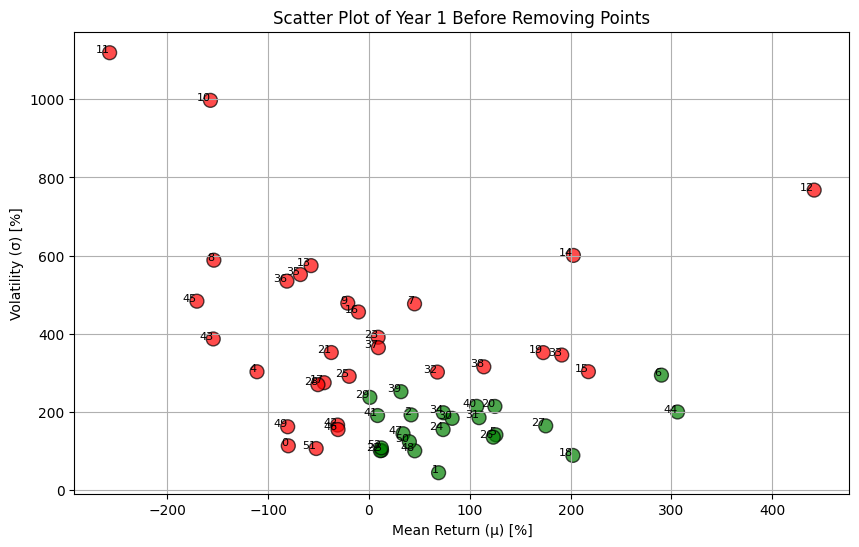

In [4]:
# Plot scatter plot for Year 1
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    year_1['mean_return'], year_1['volatility'],
    c=year_1['Label'].map({'Green': 'green', 'Red': 'red'}),
    s=100, alpha=0.7, edgecolors='black'
)

# Annotate each point with its Week Number
for i, row in year_1.iterrows():
    plt.annotate(row['Week_Number'], (row['mean_return'], row['volatility']), fontsize=8, ha='right')

plt.xlabel('Mean Return (µ) [%]')
plt.ylabel('Volatility (σ) [%]')
plt.title('Scatter Plot of Year 1 Before Removing Points')
plt.grid(True)
plt.show()

In [5]:
# Manually remove selected points for better separation
points_to_remove = [41, 39, 19, 33, 15, 29, 38]
filtered_year_1 = year_1[~year_1['Week_Number'].isin(points_to_remove)]

# Compute linear decision boundary
green_centroid = filtered_year_1[filtered_year_1['Label'] == 'Green'][['mean_return', 'volatility']].median()
red_centroid = filtered_year_1[filtered_year_1['Label'] == 'Red'][['mean_return', 'volatility']].median()

# Compute slope (m) and intercept (b)
m = (red_centroid['volatility'] - green_centroid['volatility']) / \
    (red_centroid['mean_return'] - green_centroid['mean_return'])
b = green_centroid['volatility'] - m * green_centroid['mean_return']

# Adjust line manually
m = 1.4
b = 204.53

# Display computed equation
print(f'Decision Boundary Equation: σ = {m:.2f} * µ + {b:.2f}')

Decision Boundary Equation: σ = 1.40 * µ + 204.53


In [6]:
# Apply decision boundary equation to classify Years 2-5
df_next_years = df_final[df_final['Year'] > df_final['Year'].min()].copy()

# Predict labels using the decision boundary equation
df_next_years['Predicted_Label'] = df_next_years.apply(
    lambda row: 'Red' if row['volatility'] > (m * row['mean_return'] + b) else 'Green',
    axis=1
)

# Compute accuracy per year
df_next_years['Match'] = df_next_years['Predicted_Label'] == df_next_years['Label']
accuracy_per_year = df_next_years.groupby('Year')['Match'].mean() * 100

# Display accuracy
accuracy_per_year

,Match
Year,
2021,78.846154
2022,90.384615
2023,94.230769
2024,90.566038


In [7]:
# Compute portfolio growth comparison
initial_investment = 100
portfolio_results = []

for year in df_next_years['Year'].unique():
    df_year = df_next_years[df_next_years['Year'] == year]
    strategy_balance = initial_investment
    buy_hold_balance = initial_investment

    for _, row in df_year.iterrows():
        weekly_return = row['mean_return'] / 100
        weekly_return = max(min(weekly_return, 0.5), -0.5)
        buy_hold_balance *= (1 + weekly_return)
        if row['Predicted_Label'] == 'Green':
            strategy_balance *= (1 + weekly_return)

    portfolio_results.append({
        'Year': year,
        'Strategy Growth ($)': round(strategy_balance, 2),
        'Buy & Hold Growth ($)': round(buy_hold_balance, 2)
    })

portfolio_growth_df = pd.DataFrame(portfolio_results)
portfolio_growth_df

,Year,Strategy Growth ($),Buy & Hold Growth ($)
0,2021,77244.36,98.21
1,2022,5766.50,0.00
2,2023,307220.41,1922.37
3,2024,1017140.28,535.47
